In [1]:
from config import *

In [2]:
print(f'{year}年{month}月')

2020年4月


In [3]:
import pandas as pd
import sys
sys.path.append('..')
sys.path.append('../py')
sys.path.append('../../py')
import db
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
import scipy.stats as stats
import numpy as np
import weighted
%matplotlib inline

In [4]:
conn=db.get_conn()
data=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and career='机器学习'  and monthly_salary<80000", con=conn)
conn.close()

In [5]:
#del data['publish_date']
#del data['published_on_weekend']
#del data['title']
#del data['title']
#del data['company_title']
#del data['company_description']
#del data['job_description']
#del data['job_id']

In [6]:
data=data.sort_values(by='headcount', ascending=False)
data.head(1)

,job_id,monthly_salary,headcount,title,zhinengleibie,career,real_province,province,city,company_id,...,bd_hbase,bd_storm,bd_pig,bd_mahout,bd_impala,bd_yarn,bd_alluxio,bd_flink,bd_presto,bd_heron
20,110043859,12500,31,机器学习开发工程师,高级软件工程师,机器学习,None,四川,成都,co4977334,...,False,False,False,False,False,False,False,False,False,False


In [7]:
def pd_weighted_mean(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()


# Unilateral Stats 总体统计

有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [8]:
data.shape

(368, 114)

In [9]:
data.headcount.sum()

1165

In [10]:
salary_mean=weighted.weighted_mean(data.monthly_salary.values, data.headcount.values)
q=weighted.weighted_quantile(data.monthly_salary.values,[0.025,0.25,0.5,0.75,0.975], data.headcount.values)
q

array([ 5250., 12500., 17500., 27500., 58333.])

In [11]:
print(f'{year}年{month}月中国机器学习工程师的平均工资为{salary_mean:.0f}元，工资中位数为{q[2]:.0f}元，其中95%的人的工资位于{q[0]:.0f}到{q[4]:.0f}元之间。')

2020年4月中国机器学习工程师的平均工资为21344元，工资中位数为17500元，其中95%的人的工资位于5250到58333元之间。


In [12]:
print(f'In {year}, Developers in China earn {salary_mean:.0f} Yuan as average, '
      f'the median is {q[2]:.0f} Yuan, 95% of them earn between {q[0]:.0f} and {q[4]:.0f} Yuan.')

In 2020, Developers in China earn 21344 Yuan as average, the median is 17500 Yuan, 95% of them earn between 5250 and 58333 Yuan.


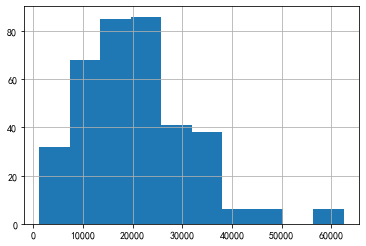

In [13]:
data.monthly_salary.hist()
plt.show()

It does not look like normal distribution.

In [14]:
from scipy import stats

## Role 角色

In [15]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]
    

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

def get_sub_stats_by_prefix(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    salary_95_min=[]
    salary_95_max=[]
    count=[]
    
    features_out=[]
    for feature in features:
        #print(feature)
        idata=data[data[feature]==1]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(weighted.weighted_mean(values, weights))
        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_median.append(q[1])
        salary_95_min.append(q[0])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        features_out.append(feature)
    sub_data=pd.DataFrame()
    sub_data['rank']=range(0,len(features_out))
    sub_data[prefix]=[f.replace(prefix,'') for f in features_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)
    sub_data['rank']=range(1,len(features_out)+1)
    #sub_data=sub_data.reset_index()
    return sub_data

def apply_style(sub_data):
    return sub_data.style.hide_index().format(
    {"salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}","percentage":"{:.2%}"})

In [16]:
data_career = get_sub_stats_by_col(data,'career')
data_career.style.format({"salary_mean":"{:.0f}","salary_median":"{:.0f}","percentage":"{:.2%}"})

,career,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
0,机器学习,21344,5250.000000,17500,58333.000000,1165,100.00%


In [17]:
np.sum(data.monthly_salary * data.headcount) / data.headcount.sum()

21344.350214592276

In [18]:
data.headcount.sum()

1165

In [19]:
data.headcount.describe()

count    368.000000
mean       3.165761
std        2.888900
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       31.000000
Name: headcount, dtype: float64

In [20]:
pd.options.display.max_columns=100


In [21]:
data.headcount.sum()

1165

# 城市

In [22]:
data_pl=get_sub_stats_by_col(data,'city')
data_pl=data_pl[data_pl['head_count']>100]
apply_style(data_pl)

city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
深圳,27900,5859,27500,58333,178,15.28%
北京,26853,5300,25000,57266,204,17.51%
上海,22915,6195,22500,46575,282,24.21%
广州,17043,5073,15000,38475,161,13.82%


In [23]:
other=1-data_pl['percentage'].sum()
other

0.29184549356223166

In [24]:
head_counts=list(data_pl['percentage'].values)
head_counts.append(other)
head_counts

labels=list(data_pl['city'].values)
labels.append('其他')

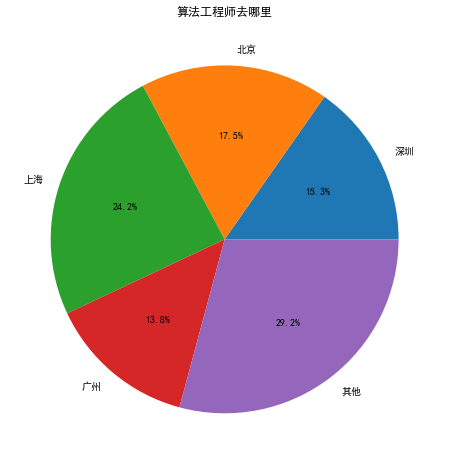

In [25]:

plt.figure(figsize=(10,8))
plt.pie(head_counts, labels=labels, autopct='%1.1f%%')
plt.title(f'算法工程师去哪里')
plt.show()

# 编程语言

In [26]:
data_pl=get_sub_stats_by_prefix(data,'pl_')
data_pl=data_pl[data_pl['head_count']>50]
apply_style(data_pl)

rank,pl_,salary_mean,salary_median,salary_95_min,salary_95_max,head_count,percentage
1,r,30711,30555,15000,58333,112,5.77%
2,matlab,28497,25000,7000,61986,137,7.06%
5,go,24122,21706,5547,39854,67,3.45%
6,java,23546,20682,9000,58333,280,14.43%
7,scala,23392,22167,17500,31500,54,2.78%
8,cpp,22790,20000,5250,58333,529,27.27%
10,python,22197,20000,5250,58333,683,35.21%


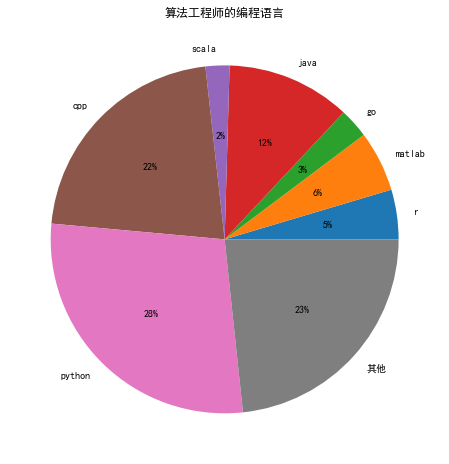

In [27]:
head_counts=list(data_pl['percentage'].values)
head_counts.append(other)
head_counts

labels=list(data_pl['pl_'].values)
labels.append('其他')

plt.figure(figsize=(10,8))
plt.pie(head_counts, labels=labels, autopct='%1.0f%%')
plt.title(f'算法工程师的编程语言')
plt.show()

## 大数据工具 

In [28]:
data_pl=get_sub_stats_by_prefix(data,'bd_')
data_pl=data_pl[data_pl['head_count']>10]
apply_style(data_pl)

rank,bd_,salary_mean,salary_median,salary_95_min,salary_95_max,head_count,percentage
2,hive,29815,30000,12500,55750,54,14.44%
3,flink,27400,24375,15000,40000,25,6.68%
4,spark,25555,24750,5129,45000,156,41.71%
5,storm,24615,35357,4500,40000,13,3.48%
6,hadoop,24357,25000,3652,39511,103,27.54%
9,hbase,19906,15000,12500,60000,16,4.28%


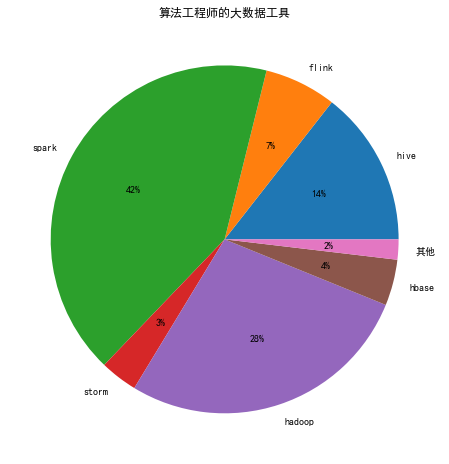

In [29]:
other=1-data_pl['percentage'].values.sum()
head_counts=list(data_pl['percentage'].values)
head_counts.append(other)
head_counts

labels=list(data_pl['bd_'].values)
labels.append('其他')

plt.figure(figsize=(10,8))
plt.pie(head_counts, labels=labels, autopct='%1.0f%%')
plt.title(f'算法工程师的大数据工具')
plt.show()

## 机器学习工具 

In [30]:
data_pl=get_sub_stats_by_prefix(data,'ml_')
data_pl=data_pl[data_pl['head_count']>100]
apply_style(data_pl)

rank,ml_,salary_mean,salary_median,salary_95_min,salary_95_max,head_count,percentage
1,mxnet,30599,22273,12975,61688,139,11.95%
3,caffe,26174,20912,11617,59947,227,19.52%
5,tensorflow,24958,20833,11469,58560,410,35.25%
6,pytorch,23142,20000,12038,53725,178,15.31%


In [31]:
data_pl['percentage'].values.sum()

0.820292347377472

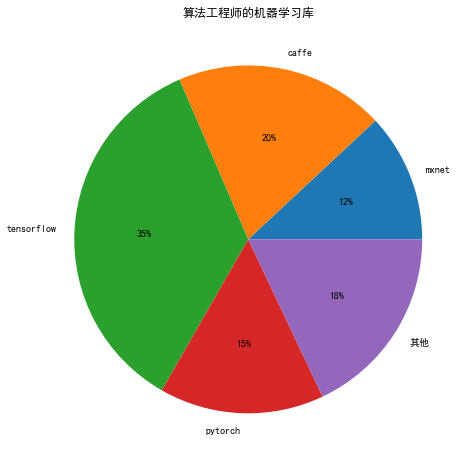

In [32]:
other=1-data_pl['percentage'].values.sum()
head_counts=list(data_pl['percentage'].values)
head_counts.append(other)
head_counts

labels=list(data_pl['ml_'].values)
labels.append('其他')

plt.figure(figsize=(10,8))
plt.pie(head_counts, labels=labels, autopct='%1.0f%%')
plt.title(f'算法工程师的机器学习库')
plt.show()

## 英语

In [33]:
all_=data.shape[0]
en=data[data['english']==1].shape[0]
other=all_-en

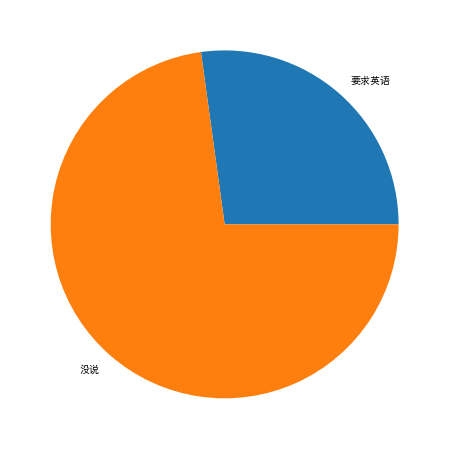

In [34]:
plt.figure(figsize=(10,8))
plt.pie([en,other], labels=['要求英语','没说'])
plt.show()

# 教育

In [35]:
edu_counts=data[~(data.edu=='')].groupby(by=['edu']).headcount.sum()

In [36]:
edu_counts

edu
初中及以下      1
博士        42
大专        72
本科       666
硕士       309
高中         2
Name: headcount, dtype: int64

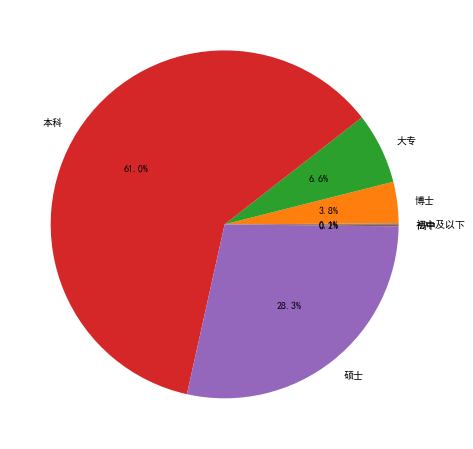

In [37]:
plt.figure(figsize=(10,8))
plt.pie(edu_counts.values, labels=edu_counts.index, autopct='%1.1f%%')
plt.show()

In [38]:
data_edu=get_sub_stats_by_col(data[data.edu.isin(['初中及以下','高中','大专','本科','硕士','博士'])], 'edu')
apply_style(data_edu)

edu,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
博士,26353,13056,26354,40000,42,3.85%
硕士,22556,7676,20000,58764,309,28.30%
本科,21596,5250,17500,57466,666,60.99%
大专,10832,2870,8500,30140,72,6.59%
高中,8375,4750,8375,12000,2,0.18%
初中及以下,5250,5250,5250,5250,1,0.09%


In [39]:
salary_associate=data[data.edu=='大专'].monthly_salary
salary_bachelor=data[data.edu=='本科'].monthly_salary
salary_master=data[data.edu=='硕士'].monthly_salary
salary_phd=data[data.edu=='博士'].monthly_salary

In [40]:
print('大专，本科，硕士，博士的平均工资分别是{:.0f}，{:.0f}，{:.0f}，{:.0f}。中位数分别是{:.0f}， {:.0f}，{:.0f}， {:.0f}。'.format(
    salary_associate.mean(),salary_bachelor.mean(),salary_master.mean(),salary_phd.mean(),
    salary_associate.median(),salary_bachelor.median(),salary_master.median(),salary_phd.median()))

大专，本科，硕士，博士的平均工资分别是11720，20646，22922，26125。中位数分别是8750， 17500，21500， 27500。


In [41]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=1.2796448756916412, pvalue=0.26049410113318994)

In [42]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=2.989612838229412, pvalue=0.08484283607531536)

In [43]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=15.37792110752103, pvalue=0.00011688101671031372)

经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

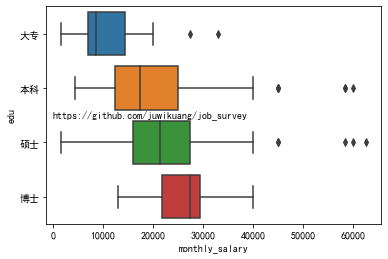

In [44]:

order=['大专','本科','硕士','博士']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [45]:
data_experience=get_sub_stats_by_col(data, 'experience')
apply_style(data_experience)

experience,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
5_10,36375,12500,33958,59833,82,7.04%
10+,28250,26500,28250,30000,2,0.17%
3_5,24669,8500,22500,45800,288,24.72%
1_3,20463,6650,17500,37500,304,26.09%
,17386,5250,15250,44183,489,41.97%


In [46]:
salary_we_10=data[data.experience=='10+'].monthly_salary
salary_we_5_10=data[data.experience=='5_10'].monthly_salary
salary_we_3_5=data[data.experience=='3_5'].monthly_salary
salary_we_1_3=data[data.experience=='1_3'].monthly_salary
salary_we_no=data[data.experience=='no'].monthly_salary

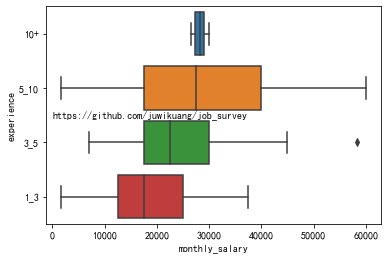

In [47]:

order=['10+','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

# 公司 Company

## 公司性质 Company Type

In [48]:
data_company_type=get_sub_stats_by_col(data,'company_type')
apply_style(data_company_type)

KeyError: 'company_type'

us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

## 公司规模 Company Size

In [ ]:
data_company_size=get_sub_stats_by_col(data,'company_size')
apply_style(data_company_size)

公司越大，工资越高

## 行业 Industry

In [ ]:
data_industry=get_sub_stats_by_col(data,'industry')
apply_style(data_industry)